# MODELS

## ARIMA

Auto Regressive Integrated Moving Average

In [41]:
!pip install pmdarima 

In [42]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib.pylab import rcParams
from pmdarima.arima import auto_arima
rcParams['figure.figsize'] = 10, 6

In [43]:
df = pd.read_csv('/kaggle/input/time-series-datasets/Electric_Production.csv')
df['DATE'] = pd.to_datetime(df['DATE'],infer_datetime_format=True)
df = df.set_index(['DATE'])
df.head(5)

,IPG2211A2N
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


### FUNCTIONALITIES TO ADD TO CLASS
        1. Train model/parameter tuning
        2. Forecasting
        3. Visualizations: Autocorrelation, Partial Autocorrelation, ETS Decomp


### Visualizations

In [44]:
df.index.name

'DATE'

In [45]:
def plot_series(df: pd.DataFrame):
    plt.xlabel(df.index.name)
    plt.ylabel(df.columns[0])
    plt.plot(df)
    plt.title('Series plot')

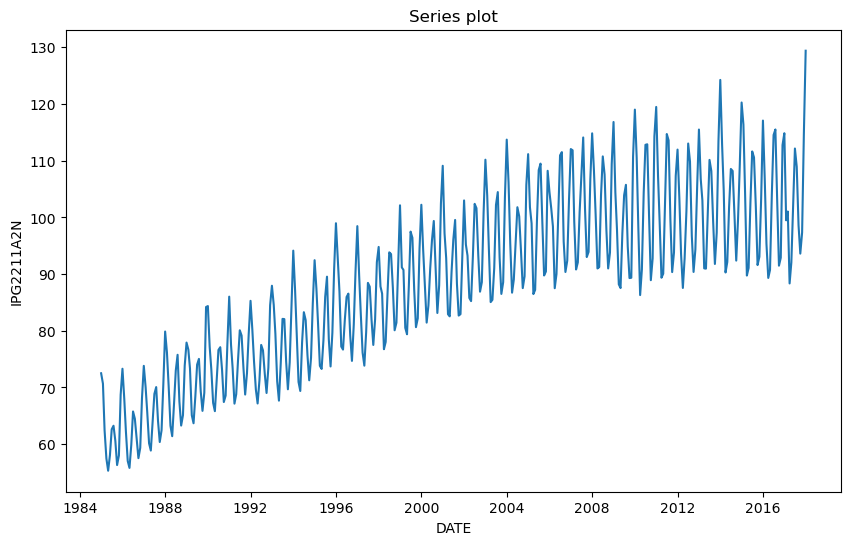

In [46]:
plot_series(df)

In [47]:
def plot_rolling_stats(df: pd.DataFrame, window: int):
    rolmean = df.rolling(window=12).mean()
    rolstd = df.rolling(window=12).std()
    orig = plt.plot(df, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

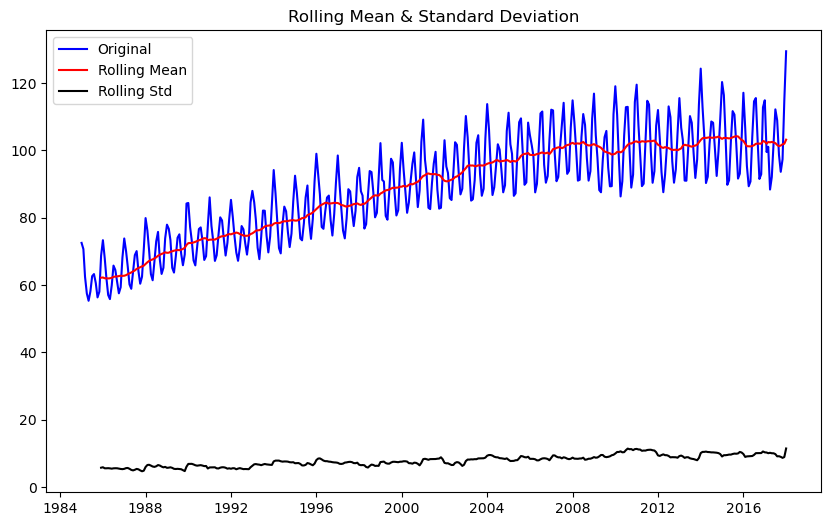

In [48]:
plot_rolling_stats(df, 12)

In [49]:
def test_stationarity(df: pd.DataFrame, col: str):
    # Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(df[col], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [50]:
test_stationarity(df, 'IPG2211A2N')

Results of Dickey Fuller Test:
Test Statistic                  -2.256990
p-value                          0.186215
#Lags Used                      15.000000
Number of Observations Used    381.000000
Critical Value (1%)             -3.447631
Critical Value (5%)             -2.869156
Critical Value (10%)            -2.570827
dtype: float64


In [51]:
def acf_differencing_plots(df, max_order):
    fig, axes = plt.subplots(max_order+1, 3)
    axes[0, 0].plot(df); axes[0, 0].set_title('Original Series')
    plot_acf(df, ax=axes[0, 1])
    plot_pacf(df, ax=axes[0, 2])
    
    
    for order in range(1, max_order+1):
        axes[order, 0].plot(df.diff(order)); axes[order, 0].set_title(str(order)+' Order Differencing')
        plot_acf(df.diff(order).dropna(), ax=axes[order, 1])
        plot_pacf(df.diff(order).dropna(), ax=axes[order, 2])
        
    plt.tight_layout()
        

/opt/conda/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/statsmodels/graphics/

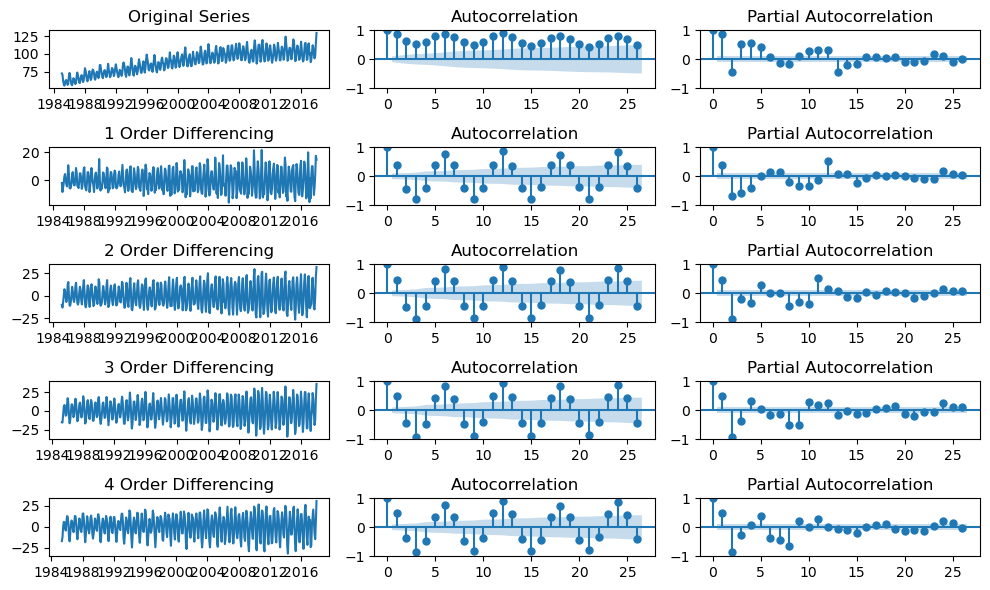

In [79]:
acf_differencing_plots(df, 4)

In [53]:
def ets_decomposition_plot(timeseries: pd.Series, plot = 'all'):
    if plot == 'all':
        seasonal_decompose(timeseries, model = 'multiplicative').plot()
    elif plot == 'seasonal':
        seasonal_decompose(timeseries, model = 'multiplicative').seasonal.plot()
    elif plot == 'error':
        seasonal_decompose(timeseries, model = 'multiplicative').resid.plot()
    elif plot == 'trend':
        seasonal_decompose(timeseries, model = 'multiplicative').trend.plot()
    else:
        print('Incorrect value \''+ plot + '\' for \'plot\'')
        
    

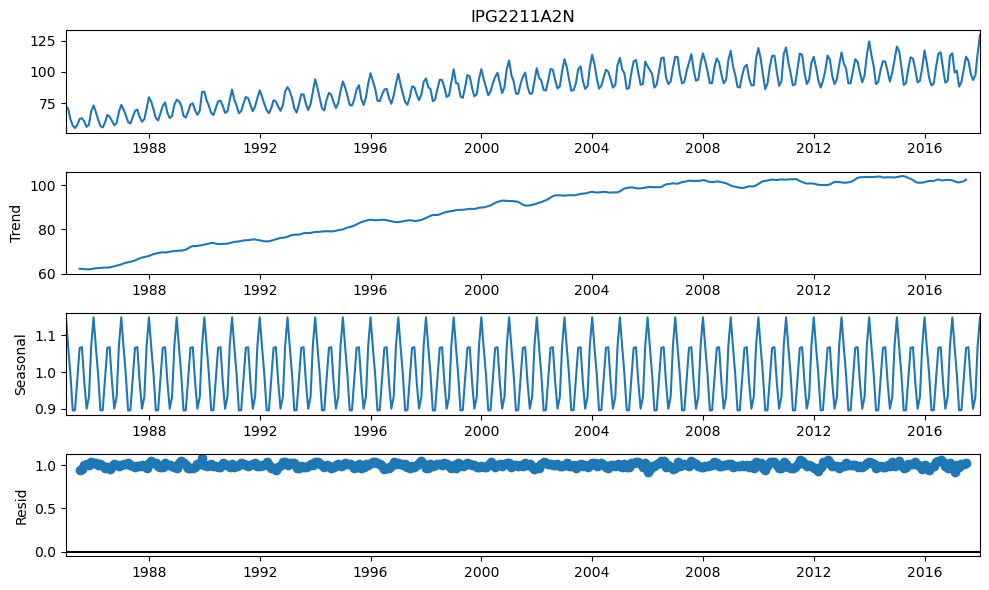

In [54]:
ets_decomposition_plot(df['IPG2211A2N'])

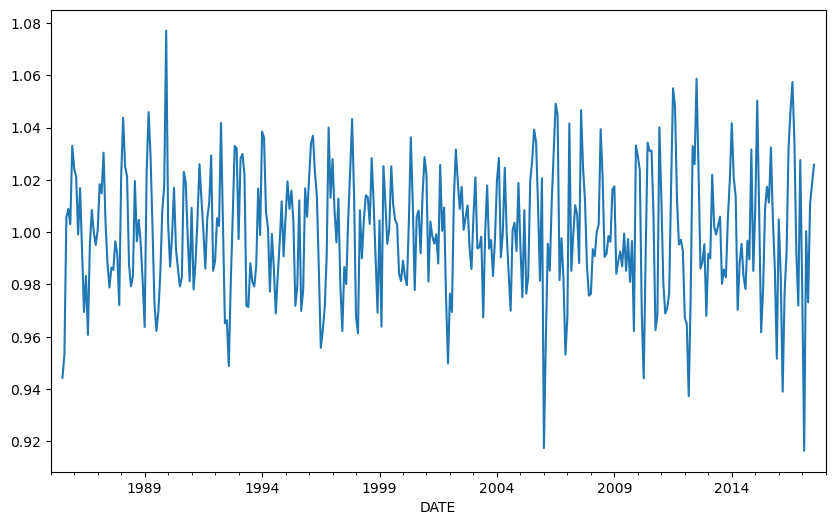

In [55]:
ets_decomposition_plot(df['IPG2211A2N'],'error')

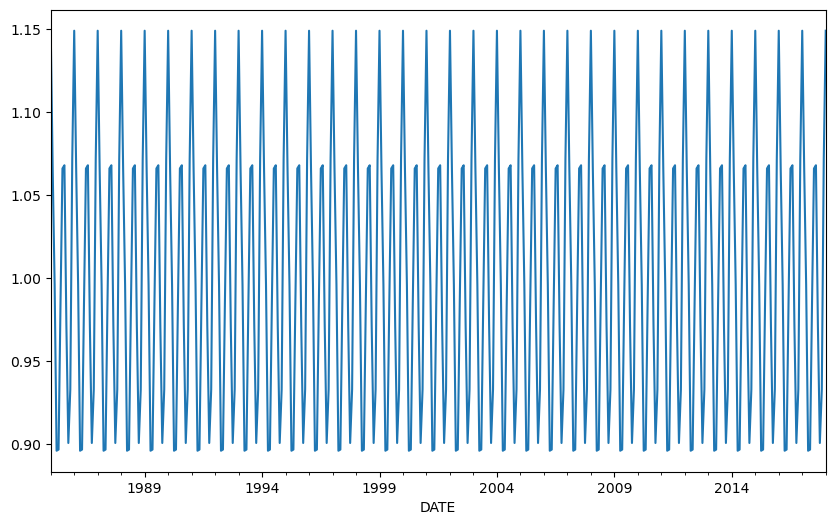

In [56]:
ets_decomposition_plot(df['IPG2211A2N'],'seasonal')

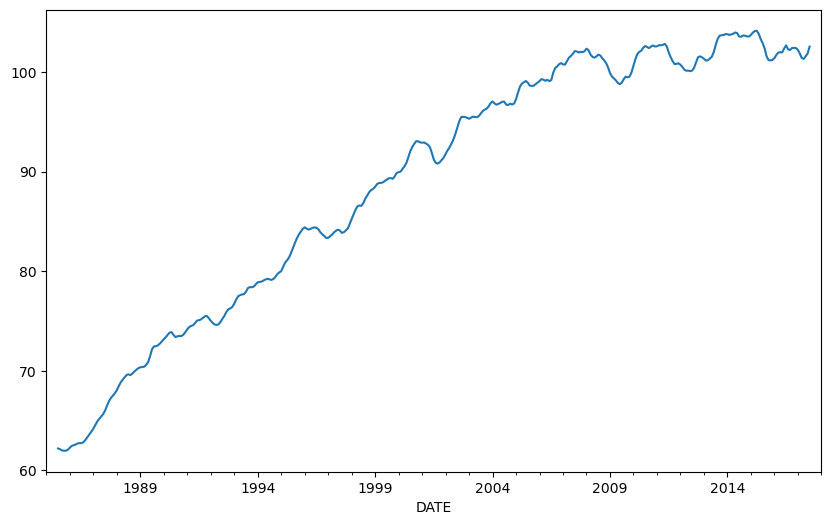

In [57]:
ets_decomposition_plot(df['IPG2211A2N'],'trend')

### Model building

In [58]:
def build_model(timeseries, order = None, show_summary = True):
#     if order is None: # auto-ARIMA
#         model = auto_arima(timeseries, start_p=1, start_q=1,
#                       test='adf',
#                       max_p=4, max_q=4, 
#                       m=1,             
#                       d=None,           
#                       seasonal=False,   
#                       start_P=0, 
#                       D=0, 
#                       trace=True,
#                       error_action='ignore',  
#                       suppress_warnings=True, 
#                       stepwise=True)
#         if show_summary:
#             print(model.summary())
#         return model
    model = ARIMA(timeseries, order=order)
    model_fit = model.fit()
    if show_summary:
        print(model_fit.summary())
    return model_fit
                      

In [59]:
# model = build_model(df['IPG2211A2N'])

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2635.437, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=4702.955, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=4185.795, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=2636.347, Time=0.10 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=2551.745, Time=0.11 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=2517.847, Time=0.16 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=2120.789, Time=0.26 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=2263.821, Time=0.21 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=2263.258, Time=0.53 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=2613.564, Time=0.52 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=2474.151, Time=0.32 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=2242.939, Time=0.23 sec
 ARIMA(4,0,3)(0,0,0)[0]             : AIC=i

In [60]:
# model.order

(4, 0, 2)

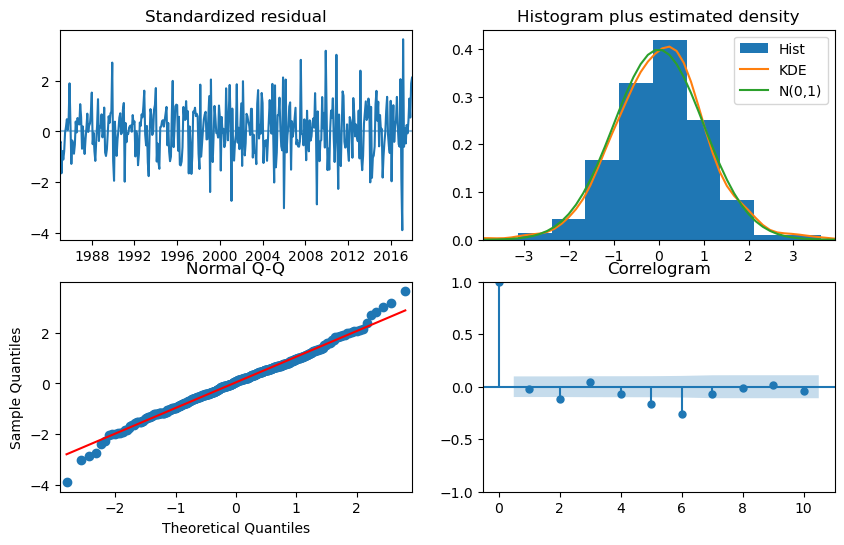

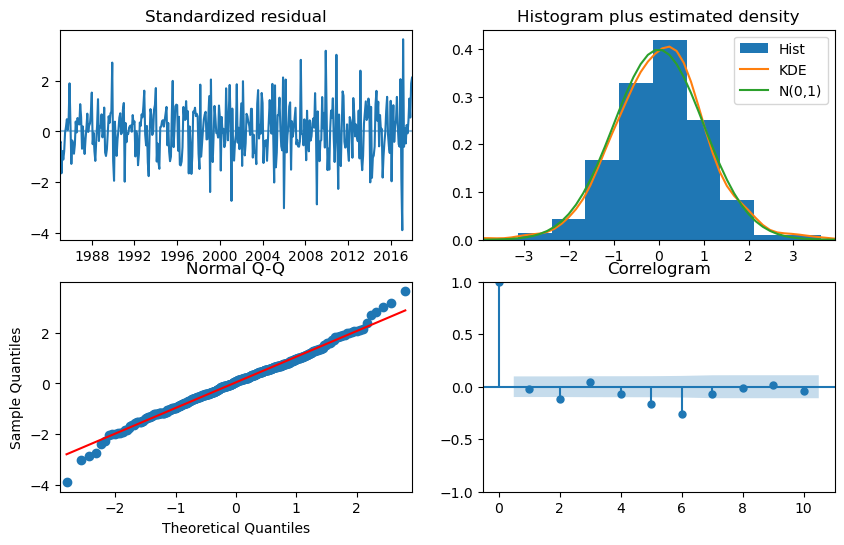

In [61]:
# model.plot_diagnostics()

In [69]:
model = build_model(df['IPG2211A2N'], order = (4, 0, 2))

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                               SARIMAX Results                                
Dep. Variable:             IPG2211A2N   No. Observations:                  397
Model:                 ARIMA(4, 0, 2)   Log Likelihood               -1121.635
Date:                Fri, 09 Jun 2023   AIC                           2259.269
Time:                        07:41:03   BIC                           2291.141
Sample:                    01-01-1985   HQIC                          2271.895
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         88.5703     24.945      3.551      0.000      39.679     137.462
ar.L1          0.9397      0.043     21.906      0.000       0.856       1.024
ar.L2          0.1244      0.048      2.604      0.0

/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### Forecasting

In [70]:
model.forecast(10)

2018-02-01    118.379881
2018-03-01     97.447893
2018-04-01     85.838786
2018-05-01     94.271901
2018-06-01    110.295831
2018-07-01    119.460386
2018-08-01    112.967146
2018-09-01    100.694192
2018-10-01     93.420744
2018-11-01     98.411020
Freq: MS, Name: predicted_mean, dtype: float64

In [71]:
df.tail(5)

,IPG2211A2N
DATE,
2017-09-01,98.6154
2017-10-01,93.6137
2017-11-01,97.3359
2017-12-01,114.7212
2018-01-01,129.4048


In [72]:
# forecast plotting

fc = model.forecast(15, alpha=0.05) 
pd.Series(fc)

2018-02-01    118.379881
2018-03-01     97.447893
2018-04-01     85.838786
2018-05-01     94.271901
2018-06-01    110.295831
2018-07-01    119.460386
2018-08-01    112.967146
2018-09-01    100.694192
2018-10-01     93.420744
2018-11-01     98.411020
2018-12-01    107.767170
2019-01-01    113.525333
2019-02-01    109.648734
2019-03-01    102.507977
2019-04-01     97.911554
Freq: MS, Name: predicted_mean, dtype: float64

In [80]:
def plot(timeseries, model, periods):
    fig = plt.figure()
    timeseries.plot()
    fc = model.forecast(periods)
    print(len(fc))
    fc.plot()


20


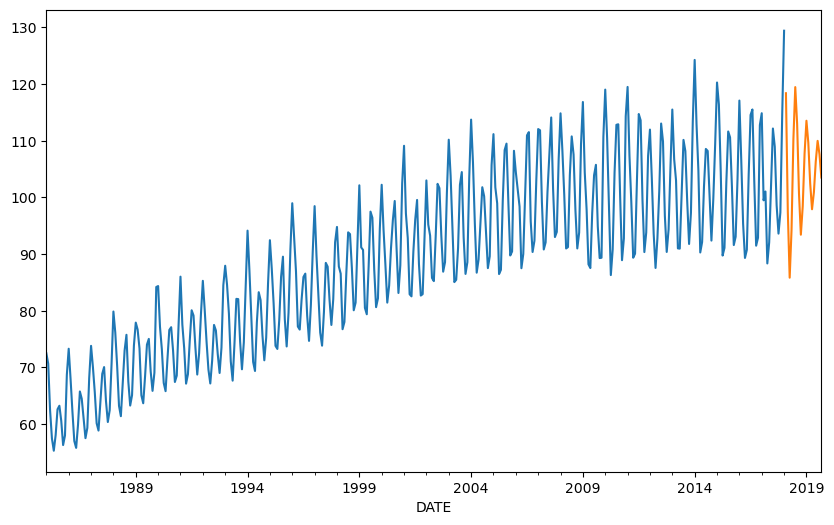

In [84]:
plot(df['IPG2211A2N'], model, 20)

## FINAL ARIMA CLASS

In [ ]:
class ModelARIMA:
    def __init__(self)